# REST API Search Endpoint

Método de consulta de tweets históricos (hasta una semana) basándose en varios criterios, es muy adecuado para un análisis estático.

## Carga inicial de datos

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
import pandas as pd
from bs4 import BeautifulSoup
import requests
from requests_oauthlib import OAuth1
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string
from pymongo import MongoClient
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import cross_val_predict
#para los otros tipos de algoritmos:
from sklearn.svm import SVC #Support Vector Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
#########################################
#Para importar y exportar el algoritmo entrenado
from pickle import dump
from pickle import load
#########################################
import csv
from nltk.tag import StanfordNERTagger
import collections.abc
import collections
import re
from collections import Counter
import numpy as np
consumer_key='ynSB0dFvqPl3xRU7AmYk39rGT'
consumer_secret='6alIXTKSxf0RE57QK3fDQ8dxdvlsVr1IRsHDZmoSlMx96YKBFD'
access_token='966591013182722049-BVXW14Hf5s6O2oIwS3vtJ3S3dOsKLbY'
access_token_secret='829DTKPjmwsSytmp1ky9fMCJkjV0LZ04TbL9oqHGV6cDm'

[nltk_data] Downloading package stopwords to C:\Users\Servicio
[nltk_data]     Técnico\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Servicio
[nltk_data]     Técnico\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Anaconda\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Parte en la que se importa las librerías necesarias.

In [2]:
q = 'premier league -filter:retweets AND -filter:replies'
url = 'https://api.Twitter.com/1.1/search/tweets.json'
pms = {'q' : q, 'count' : 100, 'lang' : 'en', 'result_type': 'recent'} 
auth = OAuth1(consumer_key, consumer_secret, access_token,access_token_secret)
#res = requests.get(url, params = pms, auth=auth)
#esta parte del código se utiliza realmente en la paginación

Sección de código que realiza la consulta **q** mediante la api de twitter utilizando los parámetros **pms**. Después, se crea una variable **auth** que corresponde a los datos exigidos por la API para conectarse que son *Las claves y los tokens de acceso.*
Por último se realiza la petición utilizando todos los datos necesarios por medio de una función de la librería requests **(request.get)** el resultado se vuelca en la variable **res**.

In [3]:
#tweets = res.json()
#esta parte del código se utiliza realmente en la paginación

Si la conección es correcta se recuperarán varios documentos que se pueden convertir a json. En el formato json es en el cual extraeremos la información que nos importa.

## Carga de datos para más de 100 tweets (Paginación)

Como twitter te permite obtener hasta 100 tweets por llamada, si queremos recuperar más, necesitamos recordar los IDs de los tweets ya descargados para no repetir tweets en las siguientes llamadas. Esto es la paginación.

In [4]:
database_name = "baseDeDatos"
collection_name = "coleccion"
client = MongoClient('mongodb://localhost:27017/')
db = client[database_name]
collection = db[collection_name]

**MongoDB** *es una base de datos NoSQL ágil orientado a documentos, esto significa que en lugar de guardar los datos en tablas como se hace en las bbdd relacionales, MongoDB guarda estructuras de datos en documentos similares a JSON con un esquema dinámico.*
En nuestro caso importamos la librería para usar el cliente y creamos una base de datos y una colección a raíz de la base de datos. Ya cambiaré los nombres de **database_name** y **collection_name**. <font color='red'>falta establecer el nombre de la base de datos y el nombre de la colección</font>

In [5]:
pages_counter = 0
number_of_pages = 1
while pages_counter < number_of_pages:
    pages_counter += 1
    res = requests.get(url, params = pms, auth=auth)
    print("Connection status: %s" % res.reason)
    tweets = res.json()
    ids = [i['id'] for i in tweets['statuses']]
    pms['max_id'] = min(ids) - 1
    collection.insert_many(tweets['statuses'])

Connection status: OK


El código para la paginación consiste en un bucle que se repetirá tantas veces como el número aproximado de tweets que queramos recuperar de twitter. Dentro del bucle se realiza la *consulta* (**requests.get**) y se guarda en la variable tweets con formato json (igual que se hacía antes de la paginación)
Después, para implementar lo que es realmente la paginación; 
- Se recolectan todos los **ids** de los tweets recogidos mediante el **get**.
- Se almacena en **i** todos los **ids** de todos los tweets.
- Se establece en **pms** como el *id mayor*, el *id mínimo* de **i** -1 (porque se incluiría y después se duplica)
- Por último se inserta en la base de datos (Con **insert_many**) todos los tweets que han sido recuperados en esta *ronda*

In [6]:
#client = MongoClient('mongodb://localhost:27017/')
#db = client['db']
#collection = db['collection']
documents = []
for doc in collection.find():
    documents.append(doc)

Lo que se hace a continuación es utilizar la base de datos de mongo en la que se ha estado almacenando los tweets para volcar la información de forma tabular, donde las columnas indican los nombres de los nodos del documento y las filas representan los datos.


In [7]:
df = pd.DataFrame(documents)

En este paso se crea un Dataframe usando la lista de documentos que hemos construido.

# Limpieza de datos

Nos gustaría analizar los sentimientos de los tweets que son escritos por la gente desde sus diferentes dispositivos. Por lo tanto, debemos deshacernos de los tweets compuestos por bots, páginas web, servicios de envío automatizado, etc. No podemos identificar esos tweets al 100%, pero es bastante buena suposición sería seleccionar tweets publicados desde dispositivos físicos, es decir, iPhones, Teléfonos Android, ordenadores de sobremesa y portátiles. 
Los documentos de Twitter tienen una característica interesante, ya que mantienen la información sobre la fuente de la creación del tweet. Cada vez que alguien usa un dispositivo para componer un tweet, el se mantiene la información al respecto.

In [8]:
df['tweet_source'] = df['source'].apply(lambda x: BeautifulSoup(x).get_text())

C:\Anaconda\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Anaconda\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Con esta linea de código vamos a crear una nueva columna en el data Frame df que se llama tweet_source y ahí vamos a poner lo que había en la columna source pero con la información que necesitamos, es decir, la fuente del tweet.
Ahora bien, sólo nos interesan los dispositivos. La información sobre los dispositivos es muy clara: encontraremos fuentes de tweets como Twitter para iPhone, Twitter para Android, Twitter Web Client, Twitter para BlackBerry, Twitter para Mac, Twitter para Windows, etc. Los nombres de los dispositivos comienzan con la palabra "Twitter". Utilizaremos esta propiedad para abordar nuestra segunda cuestión.

In [13]:
devices = list(set(df[df['tweet_source'].str.startswith('Twitter')]['tweet_source']))

['Twitter for iPhone',
 'Twitter for Android',
 'Twitter for iPad',
 'Twitter Web Client']

De esta manera se extrae en la variable devices todas las fuentes de los tweets que comiencen por Twitter, es decir, todas las que vienen de dispositivos.

In [14]:
devices.remove('Twitter Ads')
df = df[df['tweet_source'].isin(devices)]

Quitamos de la lista de dispositivos todos aquellos que sean anuncios de Twitter y dejamos en el data frame sólamente aquellos twits cuya fuente sea la misma que la que tenemos en devices.

In [15]:
df = df[~df['text'].str.contains("Ghana|ghana|jamaica|Jamaica|Ladbrokes|India|Pa kistan|Ghana Premier League|Vijay|Predictions|Egyptian Premier League|cricket|Kings|Caribbean Premier League|@cricbuzz|Cricinfo")]

En este punto lo que se hace en el libro (quizá yo no tenga que hacerlo) es eliminar la posibilidad de que salgan twits de Premiere League que no sea la inglesa. Hay otras Premiere League que no interesa para el estudio del libro y se quita mediante esta función utilizando las palabras clave que necesitemos. Toda esta búsqueda para la limpieza se realiza en el campo text de df (df.text)
El código dice, en esencia, mantiene todas las filas que NO (~) tengan en la columa "text" las siguientes palabras (| es el operador lógico OR)

In [16]:
#TOKENIZATION
df['tokens'] = df['text'].apply(TweetTokenizer().tokenize)
#STOPWORDS
stopwords_vocabulary = stopwords.words('english') #estará en español?
df['stopwords'] = df['tokens'].apply(lambda x: [i for i in x if i.lower() not in stopwords_vocabulary])
#SPECIAL CHARACTERS AND STOPWORDS REMOVAL
punctuations = list(string.punctuation)
df['punctuation'] = df['stopwords'].apply(lambda x: [i for i in x if i not in punctuations])
df['digits'] = df['punctuation'].apply(lambda x: [i for i in x if i[0] not in list(string.digits)])
df['final'] = df['digits'].apply(lambda x: [i for i in x if len(i) > 1])

# Análisis de Sentimientos
Utilizaremos VADER para analizar los sentimientos de los datos que hemos recibido.

In [17]:
#importamos las librerías que necesitamos
sentiment = SentimentIntensityAnalyzer()
df['sentiment'] = df.text.apply(lambda x: sentiment.polarity_scores(x)['compound'])

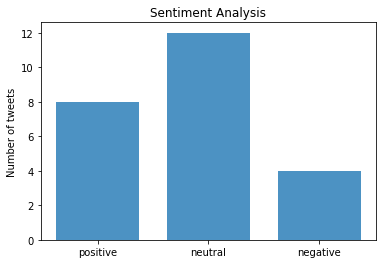

In [18]:
pos = len(df[df.sentiment > 0]) #guardamos la cantidad de tweets positivos
neg = len(df[df.sentiment < 0]) #guardamos la cantidad de tweets negativos
neu = len(df[df.sentiment == 0]) #guardamos la cantidad de tweets neutros
y = [pos, neu, neg] # vector de la cantidad de tweets positivos, negativos y neutros
#construimos un gráfico con los datos del vector
plt.title("Sentiment Analysis")
plt.ylabel('Number of tweets')
plt.xticks(range(len(y)), ['positive', 'neutral', 'negative'])
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8)
plt.show()

# Etiquetado de los datos

In [19]:
classes = ['4', '2', '0']
filename = 'testdata.manual.2009.06.14.csv'
filename2 = 'prueba.csv'
dataset = pd.read_csv(filename)
tweetys = dataset['final']
prueba = pd.read_csv(filename) #para la última parte del NER combinado
dataset2 = pd.read_csv(filename2)
print("1. Carga de archivos realizada")

#LIMPIEZA DE DATOS DE DATASET
#TOKENIZATION
dataset['tokens'] = dataset['final'].apply(TweetTokenizer().tokenize)
#STOPWORDS
stopwords_vocabulary = stopwords.words('english') #estará en español?
dataset['stopwords'] = dataset['tokens'].apply(lambda x: [i for i in x if i.lower() not in stopwords_vocabulary])
#SPECIAL CHARACTERS AND STOPWORDS REMOVAL
punctuations = list(string.punctuation)
dataset['punctuation'] = dataset['stopwords'].apply(lambda x: [i for i in x if i not in punctuations])
dataset['digits'] = dataset['punctuation'].apply(lambda x: [i for i in x if i[0] not in list(string.digits)])
dataset['final'] = dataset['digits'].apply(lambda x: [i for i in x if len(i) > 1])
print("2. Limpieza del dataset realizada")

#LIMPIEZA DE DATOS DE DATASET2
#TOKENIZATION
dataset2['tokens'] = dataset2['final'].apply(TweetTokenizer().tokenize)
#STOPWORDS
stopwords_vocabulary = stopwords.words('english') #estará en español?
dataset2['stopwords'] = dataset2['tokens'].apply(lambda x: [i for i in x if i.lower() not in stopwords_vocabulary])
#SPECIAL CHARACTERS AND STOPWORDS REMOVAL
punctuations = list(string.punctuation)
dataset2['punctuation'] = dataset2['stopwords'].apply(lambda x: [i for i in x if i not in punctuations])
dataset2['digits'] = dataset2['punctuation'].apply(lambda x: [i for i in x if i[0] not in list(string.digits)])
dataset2['final'] = dataset2['digits'].apply(lambda x: [i for i in x if len(i) > 1])
print("3. Limpieza del dataset2 realizada")

#Aquí es el lugar donde defino el número de tweets que usaré en los modelos siempre con el porcentaje 80:20
train_data = dataset2['final'][0:300]
train_labels = dataset2['label'][0:300]

test_data = dataset['final'][0:75]
test_labels = dataset['label'][0:75]

train_data = list(train_data.apply(' '.join))
test_data = list(test_data.apply(' '.join))

1. Carga de archivos realizada
2. Limpieza del dataset realizada
3. Limpieza del dataset2 realizada


In [89]:
test_data

['@stellargirl loooooooovvvvvveee Kindle DX cool fantastic right',
 'Reading kindle ... Love ... Lee childs good read',
 'Ok first assesment #kindle2 ... fucking rocks',
 "@kenburbary love Kindle I've mine months never looked back new big one huge need remorse :)",
 '@mikefish Fair enough Kindle think perfect :)',
 "@richardebaker big I'm quite happy Kindle",
 'Fuck economy hate aig non loan given asses',
 'Jquery new best friend',
 'Loves twitter',
 'love Obama makes jokes',
 'Check video President Obama White House Correspondents Dinner http://bit.ly/IMXUM',
 '@Karoli firmly believe Obama Pelosi ZERO desire civil charade slogan want destroy conservatism',
 'House Correspondents dinner last night whoopi barbara sherri went Obama got standing ovation',
 'Watchin Espn .. Jus seen new Nike Commerical Puppet Lebron .. sh hilarious ... LMAO',
 'dear nike stop flywire shit waste science ugly love @vincentx24x',
 '#lebron best athlete generation time basketball related want get inter-sport d

# Preparación de los datos para los modelos
se prepara la información para dejarla de manera adecuada lista para los modelos

In [85]:
vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf=True)
#min_df = 5. Descarta palabras que aparezcan en menos de 5 tweets.
#max_df = 0.8 Descarta palabras que aparezcan en más del 80% de los tweets
#sublinear_tf = True Le da una importancia logarítmica a la repetición de palabras
#use_idf = True Permite la frecuencia inversa del documento ???
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [91]:
print(test_vectors)

  (1, 30)	0.7566258638880964
  (1, 18)	0.6538480726404199
  (3, 58)	0.4193979846865096
  (3, 39)	0.4329765957271401
  (3, 36)	0.4193979846865096
  (3, 35)	0.4076356567863411
  (3, 30)	0.4076356567863411
  (3, 0)	0.3583409983061691
  (4, 51)	1.0
  (6, 21)	1.0
  (7, 36)	1.0
  (9, 30)	1.0
  (10, 25)	0.6854790724168764
  (10, 24)	0.7280923301879362
  (11, 60)	1.0
  (12, 37)	0.5641784811678414
  (12, 24)	0.6149014273164514
  (12, 19)	0.5509980726566459
  (13, 36)	1.0
  (14, 30)	1.0
  (15, 60)	0.5982372933425959
  (15, 53)	0.5982372933425959
  (15, 14)	0.5331268908132939
  (16, 37)	0.6760624044086405
  (16, 20)	0.7368443698266329
  :	:
  (56, 25)	0.6854790724168764
  (56, 6)	0.7280923301879362
  (58, 36)	0.6957540575129336
  (58, 31)	0.7182800926200652
  (59, 17)	1.0
  (60, 49)	0.4369104893054235
  (60, 36)	0.42320850713734204
  (60, 35)	0.4113393103055759
  (60, 28)	0.3752987577286883
  (60, 13)	0.42320850713734204
  (60, 12)	0.3752987577286883
  (64, 18)	1.0
  (67, 25)	0.6854790724168764
 

# Creación del modelo para Navie Bayes
Según el ejemplo del libro

In [86]:
nb = MultinomialNB()
#nb.fit(train_vectors, train_labels).score(test_vectors, test_labels)
#Para guardar el entrenamiento del modelo
#file = open('NaiveBayes', 'wb')
#dump(nb, file)
#Para cargar el entrenamiento del modelo
file = open('NaiveBayes', 'rb')
nb = load(file)

In [87]:
print("Naive Bayes")
print(classification_report(test_labels, nb.predict(test_vectors)))
print(confusion_matrix(test_labels, nb.predict(test_vectors)))
predicted = cross_val_predict(nb, test_vectors, test_labels, cv=10)
print("Cross validation %s" % accuracy_score(test_labels, predicted))

Naive Bayes
             precision    recall  f1-score   support

          0       0.50      0.33      0.40        21
          2       0.21      0.57      0.30        14
          4       0.55      0.30      0.39        40

avg / total       0.47      0.36      0.37        75

[[ 7  9  5]
 [ 1  8  5]
 [ 6 22 12]]


C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\ne

Cross validation 0.49333333333333335


C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[2 2 2 2 2 2 0 2 2 4 2 0 2 2 4 4 4 4 2 2 4 2 2 0 0 0 0 2 4 4 2 4 0 2 4 2 2
 2 4 2 0 2 2 0 0 2 2 0 4 2 0 2 2 2 4 4 4 2 4 2 2 2 2 2 0 2 2 4 2 4 4 4 0 4
 4]


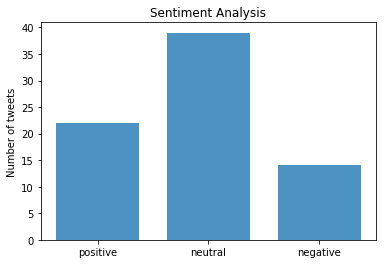

In [80]:
result = nb.predict(test_vectors)
print(result)
pos = len(result[result == 4]) #guardamos la cantidad de tweets positivos
neg = len(result[result == 0]) #guardamos la cantidad de tweets negativos
neu = len(result[result == 2]) #guardamos la cantidad de tweets neutros
y = [pos, neu, neg] # vector de la cantidad de tweets positivos, negativos y neutros
#construimos un gráfico con los datos del vector
plt.title("Sentiment Analysis")
plt.ylabel('Number of tweets')
plt.xticks(range(len(y)), ['positive', 'neutral', 'negative'])
plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8)
plt.show()

# Creación del modelo para SVC

In [17]:
msvc = SVC()
msvc.fit(train_vectors, train_labels).score(test_vectors, test_labels)

0.28

In [18]:
print("SVC")
print(classification_report(test_labels, msvc.predict(test_vectors)))
print(confusion_matrix(test_labels, msvc.predict(test_vectors)))
predicted = cross_val_predict(msvc, test_vectors, test_labels, cv=10)
print("Cross validation %s" % accuracy_score(test_labels, predicted))

SVC
             precision    recall  f1-score   support

          0       0.28      1.00      0.44        21
          2       0.00      0.00      0.00        14
          4       0.00      0.00      0.00        40

avg / total       0.08      0.28      0.12        75

[[21  0  0]
 [14  0  0]
 [40  0  0]]
Cross validation 0.5333333333333333


C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Creación del modelo para KNeighborsClassifier

In [49]:
neigh = KNeighborsClassifier()
neigh.fit(train_vectors, train_labels).score(test_vectors, test_labels)

0.24

In [51]:
print("KNeighbors Classifier")
print(classification_report(test_labels, neigh.predict(test_vectors)))
print(confusion_matrix(test_labels, neigh.predict(test_vectors)))
predicted = cross_val_predict(neigh, test_vectors, test_labels, cv=10)
print("Cross validation %s" % accuracy_score(test_labels, predicted))

KNeighbors Classifier
             precision    recall  f1-score   support

          0       0.23      0.52      0.32        21
          2       0.15      0.21      0.18        14
          4       0.50      0.10      0.17        40

avg / total       0.36      0.24      0.21        75

[[11  8  2]
 [ 9  3  2]
 [27  9  4]]
Cross validation 0.37333333333333335


# Creación del modelo para DessisionTreeClassifier

In [52]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(train_vectors, train_labels).score(test_vectors, test_labels)

0.3466666666666667

In [53]:
print("DecisionTreeClassifier")
print(classification_report(test_labels, tree.predict(test_vectors)))
print(confusion_matrix(test_labels, tree.predict(test_vectors)))
predicted = cross_val_predict(tree, test_vectors, test_labels, cv=10)
print("Cross validation %s" % accuracy_score(test_labels, predicted))

KNeighbors Classifier
             precision    recall  f1-score   support

          0       0.50      0.33      0.40        21
          2       0.20      0.57      0.29        14
          4       0.55      0.28      0.37        40

avg / total       0.47      0.35      0.36        75

[[ 7 10  4]
 [ 1  8  5]
 [ 6 23 11]]
Cross validation 0.49333333333333335


# Creación del modelo para MLP Perceptrion Classifier

In [54]:
mlp = MLPClassifier()
mlp.fit(train_vectors, train_labels).score(test_vectors, test_labels)

C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.3333333333333333

In [55]:
print("MLPClassifier")
print(classification_report(test_labels, mlp.predict(test_vectors)))
print(confusion_matrix(test_labels, mlp.predict(test_vectors)))
predicted = cross_val_predict(mlp, test_vectors, test_labels, cv=10)
print("Cross validation %s" % accuracy_score(test_labels, predicted))

MLPClassifier
             precision    recall  f1-score   support

          0       0.50      0.29      0.36        21
          2       0.19      0.57      0.29        14
          4       0.52      0.28      0.36        40

avg / total       0.45      0.33      0.35        75

[[ 6 10  5]
 [ 1  8  5]
 [ 5 24 11]]


C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\ne

Cross validation 0.5066666666666667


C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# NER Name Entity Recognition
En la siguiente sección implementamos el reconocimiento de entidades. Es muy lento, así que vamos a tener que ver cómo acelerar el proceso.

In [18]:
st = StanfordNERTagger(r'C:\Users\Servicio Técnico\Documents\stanford-ner-2018-02-27\classifiers\english.all.3class.distsim.crf.ser.gz')
#acuérdate de que cambia para el mac que es donde vas a realizar la presentación
entities = []

for r in tweetys:
    #print("está analizando(r): ", r)
    lst_tags = st.tag(r) #no tengo que hacer el split porque ya está hecho?
    for tup in lst_tags:
        #print("está analizando(tup): ", tup)
        if(tup[1] != 'O'):
            #print("mete(tup) ", tup, "en las entidades")
            entities.append(tup)
df_entities = pd.DataFrame(entities)
df_entities.columns = ["word","ner"]
#Organizaciones
organizations =df_entities[df_entities['ner'].str.contains("ORGANIZATION")]
cnt = Counter(organizations['word'])
cnt.most_common(10)


# 1. Coger datos de twitter.
# 2. Cargar un csv con datos y verlo en una gráfica y usar NER.
# 3. Tweet por tweet determinar de qué está hablando y el sentimiento.

C:\Anaconda\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


[('GM', 20),
 ('Time', 20),
 ('Warner', 20),
 ('Nike', 16),
 ('Google', 11),
 ('Stanford', 10),
 ('Safeway', 6),
 ('Canon', 5),
 ('New', 5),
 ('AIG', 4)]

In [19]:
#Personas
person =df_entities[df_entities['ner'].str.contains("PERSON")]
cnt_person = Counter(person['word'])
cnt_person.most_common(10)

[('Obama', 11),
 ('Malcolm', 7),
 ('Warren', 7),
 ('Bobby', 7),
 ('Gladwell', 6),
 ('Flay', 6),
 ('Pelosi', 5),
 ('Buffet', 5),
 ('Kobe', 4),
 ('Booz', 3)]

In [20]:
#Localizaciones
locations =df_entities[df_entities['ner'].str.contains("LOCATION")]
cnt_location = Counter(locations['word'])
cnt_location.most_common(10)

[('China', 9),
 ('San', 8),
 ('Francisco', 8),
 ('North', 6),
 ('Korea', 6),
 ('Iran', 4),
 ('Bay', 2),
 ('East', 2),
 ('Palo', 2),
 ('Alto', 2)]

# Combinando NER con el análisis de sentimientos.
Lo que vamos a hacer ahora es combinar el reconocimiento de entidades con el análisis de sentimientos. En el libro lo pone de manera explícita, pero vamos a tratar de hacerlo de manera automática.
Es decir vamos a coger el primero de todas las organizaciones, personas y lugares.

In [21]:
subset = prueba[prueba['final'].str.contains(cnt_person.most_common(2)[1][0])]
avg_sentiment = np.mean(subset['label'])
avg_sentiment
#subset = dataset[dataset['final'].str.contains(cnt_person.most_common(1)[0][0])]
#avg_sentiment = np.mean(subset['label'])

3.142857142857143